# Experiment with `Data Assimilation- Observed-simulation ENKF`

In [1]:
import sys 
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, './CFE')
import bmi_cfe
import bmi_cfe_peturb

sys.path.insert(0, './Assimilation')

import Bmi_da_ENKF_forSBMI
import EnKF
import sys

#sys.path.append('/home/jovyan/data/NextGen---The-Simulators-/USGS/USGS_BMI_FT/cleaned_FT')
#sys.path.append('/Assimilators_FTD/NextGen---The-Simulators-/NextGen---The-Simulators-/USGS/NextGen---The-Simulators-/USGS/USGS_BMI_FT/cleaned_FT/KalmanFilters/NextGen---The-Simulators-/Toy_Model/Assimilation/NextGen---The-Simulators-/USGS/USGS_BMI_FT')
sys.path.insert(0, '../USGS/USGS_BMI_FT')
import bmi_usgs


In [2]:
EnKF_instance = Bmi_da_ENKF_forSBMI.EnKF_wrap()
usgs = bmi_usgs.BMI_USGS()
cfe_instance_peturb = bmi_cfe_peturb.BMI_CFE()
cfe_instance = bmi_cfe.BMI_CFE() #one that changes state vars

print("Input variables:\n")
print("USGS")
print(usgs.get_input_var_names())
print("CFE")
print(cfe_instance_peturb.get_input_var_names())
print("EnKF")
print(EnKF_instance.get_input_var_names())

print("\nOutput variables:")
#print(cfe_assimilation.get_output_var_names())
print(usgs.get_output_var_names())


Input variables:

USGS
['sites', 'service', 'start', 'end']
CFE
['atmosphere_water__time_integral_of_precipitation_mass_flux', 'water_potential_evaporation_flux']
EnKF
['x', 'P', 'z', 'F', 'dt', 'N', 'look_up_table']

Output variables:
['Flow', 'validity']


In [3]:
EnKF_instance.initialize(cfg_file='./Assimilation/EnKF_config.json')
usgs.initialize(cfg_file='../USGS/USGS_BMI_FT/usgs_config.json')
cfe_instance_peturb.initialize(cfg_file='./CFE/cat_58_config_cfe_peturb_model.json')
cfe_instance.initialize(cfg_file='./CFE/cat_58_config_cfe.json')

                          Date  Flow  validity
0    2016-04-01 06:00:00+00:00   NaN       0.0
1    2016-04-01 07:00:00+00:00   NaN       0.0
2    2016-04-01 08:00:00+00:00   NaN       0.0
3    2016-04-01 09:00:00+00:00   NaN       0.0
4    2016-04-01 10:00:00+00:00   NaN       0.0
...                        ...   ...       ...
4484 2016-10-05 02:00:00+00:00  28.8       1.0
4485 2016-10-05 03:00:00+00:00  28.8       1.0
4486 2016-10-05 04:00:00+00:00  28.8       1.0
4487 2016-10-05 05:00:00+00:00  28.5       1.0
4488 2016-10-05 06:00:00+00:00   NaN       0.0

[4489 rows x 3 columns]
USGS station ID 06006000


/home/jovyan/data/Assimilators_FTD/NextGen---The-Simulators-/NextGen---The-Simulators-/USGS/NextGen---The-Simulators-/USGS/USGS_BMI_FT/cleaned_FT/KalmanFilters/NextGen---The-Simulators-/Toy_Model/./Assimilation/EnKF.py:61: RuntimeWarning: invalid value encountered in floor_divide
  e.factor=e.res//e.x



GLOBAL MASS BALANCE
  initial volume:   0.5956
    volume input: 259.2000
   volume output: 248.2436
    final volume:   0.8880
        residual: 8.5265e-14

SCHAAKE MASS BALANCE
  surface runoff: 258.9076
    infiltration:   0.2924
schaake residual: 3.0087e-14

GIUH MASS BALANCE
  vol. into giuh: 258.9076
   vol. out giuh: 248.2436
 vol. end giuh q:  10.6640
   giuh residual: 7.2831e-14

SOIL WATER CONCEPTUAL RESERVOIR MASS BALANCE
   init soil vol:   0.5856
  vol. into soil:   0.2924
vol.soil2latflow:   0.0000
 vol. soil to gw:   0.0000
 final vol. soil:   0.8780
vol. soil resid.: 1.1102e-16

NASH CASCADE CONCEPTUAL RESERVOIR MASS BALANCE
    vol. to nash:   0.0000
  vol. from nash:   0.0000
 final vol. nash:   0.0000
nash casc resid.: 0.0000e+00

GROUNDWATER CONCEPTUAL RESERVOIR MASS BALANCE
init gw. storage:   0.0100
       vol to gw:   0.0000
     vol from gw:   0.0000
final gw.storage:   0.0100
    gw. residual: 0.0000e+00


/opt/conda/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


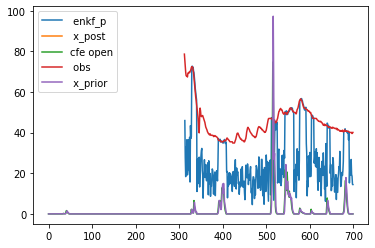

In [4]:
# ## Open BMI's for each file
cfe_open = bmi_cfe.BMI_CFE()
cfe_peturbed = bmi_cfe_peturb.BMI_CFE()
cfe_analysis = bmi_cfe.BMI_CFE() #true model in the end
# #enkf = Bmi_da_ENKF.EnsembleKalmanFilter()
# usgs = bmi_usgs.BMI_USGS()
# ######################################################################
# EnKF_instance.initialize(cfg_file='./Assimilation/EnKF_config.json')
# usgs.initialize(cfg_file='../USGS/USGS_BMI_FT/usgs_config.json')
cfe_peturbed.initialize(cfg_file='./CFE/cat_58_config_cfe_peturb_model.json')
cfe_analysis.initialize(cfg_file='./CFE/cat_58_config_cfe.json')
cfe_open.initialize (cfg_file='./CFE/cat_58_config_cfe.json')
# ######################################################################

with open(cfe_open.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)

#print(df_forcing)
#####################################
cfeOpen = []
cfePeturbed = []
sim = []
obs = []
assimilation = []
x_post=[]
x_prior=[]
enkf_pred=[]

# Update usgs data and get value to put into EnKF
usgs.update()
obs = usgs.get_value('Flow')

## Loop through time. Set values for each model and get values
for i, precip in enumerate(df_forcing['APCP_surface']): #i is 
    obs=np.array(usgs.get_value('Flow'))
    framework_time = (1+i)*3600 #seconds since starting simulation
    
    # Set values for each model
    cfe_open.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) #value of precip from forcing data in loop
    cfe_peturbed.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    cfe_analysis.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    
    # Update CFE open and peturbed. Get value for peturbed stats. 
    cfe_open.update()
    cfe_peturbed.update()   
    
    # Get values for plotting
    outflow = cfe_open.get_value('land_surface_water__runoff_depth')
    cfeOpen.append(outflow)
    outflow_peturb = cfe_peturbed.get_value('land_surface_water__runoff_depth_ens')
    
    # Get mean and covariance for stats of ensemble runs for EnKF
    outflow_peturb_mean = np.mean(outflow_peturb)
    outflow_peturb_covar = np.cov(outflow_peturb)
    cfePeturbed.append(outflow_peturb_mean)
    
    # EnKF
    EnKF_instance.set_value('x',np.array([outflow_peturb_mean]))
    EnKF_instance.set_value('P',np.array([outflow_peturb_covar]))
    EnKF_instance.set_value('z',np.array([obs[i]]))
    # EnKF_instance.set_value('dt', framework_time)
    # EnKF_instance.set_value('F', framework_time
    
    enkf_p=EnKF_instance.get_value('enkf')
    # print('enkf_p',enkf_p)
    xpo=EnKF_instance.get_value('x_post')
    xpr=EnKF_instance.get_value('x_prior')
    
    EnKF_instance.set_value('z',np.array([obs[i]]))
    # print(EnKF_instance.get_value('x'))
    EnKF_instance.update()
    fac=EnKF_instance.get_value('factor')
    F=EnKF_instance.set_value('F',fac)
    
    # print(EnKF_instance.get_value('x_prior'))
    # print("enkfz",EnKF_instance.get_value('z'),"z",np.array([obs[i]/10]))
    # print(EnKF_instance.get_value('F'))
    x_post.append(xpo)
    x_prior.append(xpr)
    enkf_pred.append(enkf_p)
    # factor.append(fac)
       
    # Set EnKF value to usgs, mean, and covariance. Get value from it then
    #enkf.set_value(obs, outflow_peturb_mean, outflow_peturb_covar)
    #state_transition = enkf.get_value('What are we getting?')
    
    # Set value for CFE analysis to get true streamflow. Update then
    #cfe_analysis.set_value(state_transition)   
    #cfe_analysis.update()
    
    # Update final model from value of analysis
    #cfe_updated_everything = cfe_analysis.get_value('Streamflow?')
    #cfe_perturbed.set_value(cfe_updated_everything)
    
# Finalize models
cfe_open.finalize(print_mass_balance=True)
cfe_peturbed.finalize()
#cfe_analysis.finalize()
usgs.finalize()
#enkf.finalize()
plt.plot(enkf_pred[:700],label=' enkf_p')
plt.plot(x_post[:700],label=' x_post')
plt.plot(cfeOpen[:700],label='cfe open')
plt.plot(obs[:700],label=' obs')


plt.plot(x_prior[:700],label=' x_prior')
plt.legend(loc=2)
# print(EnKF_instance.get_value('x_post'))

In [ ]:
EnKF_instance.finalize(print_output=True)
# missing value check

0     78.650
1     75.675
2     72.050
3     69.675
4     68.000
5     68.000
6     67.800
7     67.400
8     69.250
9     69.250
10    69.700
11    69.700
12    69.475
13    70.100
14    70.500
15    71.175
16    72.075
17    72.500
18    73.000
19    60.000
20    56.000
21    55.000
22    55.000
23    56.000
24    58.000
25    60.000
26    55.000
27       NaN
28    53.625
29    51.925
30    50.250
31    48.050
32    45.250
33    40.750
34    39.900
35    47.575
36    52.100
37    50.825
38    48.400
39    47.875
40    48.050
41    48.400
42    48.400
43    47.700
44    47.000
45    46.125
46    45.600
47    45.075
48    43.850
49    42.800
Name: Flow, dtype: float64

GLOBAL MASS BALANCE
  initial volume:   0.5956
    volume input: 259.2000
   volume output: 248.2436
    final volume:   0.8880
        residual: 8.5265e-14

SCHAAKE MASS BALANCE
  surface runoff: 258.9076
    infiltration:   0.2924
schaake residual: 3.0087e-14

GIUH MASS BALANCE
  vol. into giuh: 258.9076
   vol. out gi

AttributeError: 'numpy.float64' object has no attribute 'isNull'

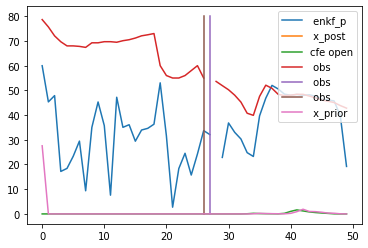

In [8]:
# for missing value check
# ## Open BMI's for each file
cfe_open = bmi_cfe.BMI_CFE()
cfe_peturbed = bmi_cfe_peturb.BMI_CFE()
cfe_analysis = bmi_cfe.BMI_CFE() #true model in the end
# #enkf = Bmi_da_ENKF.EnsembleKalmanFilter()
# usgs = bmi_usgs.BMI_USGS()
# ######################################################################
# EnKF_instance.initialize(cfg_file='./Assimilation/EnKF_config.json')
# usgs.initialize(cfg_file='../USGS/USGS_BMI_FT/usgs_config.json')
cfe_peturbed.initialize(cfg_file='./CFE/cat_58_config_cfe_peturb_model.json')
cfe_analysis.initialize(cfg_file='./CFE/cat_58_config_cfe.json')
cfe_open.initialize (cfg_file='./CFE/cat_58_config_cfe.json')
# ######################################################################

with open(cfe_open.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)

#print(df_forcing)
#####################################
cfeOpen = []
cfePeturbed = []
sim = []
obs = []
assimilation = []
x_post=[]
x_prior=[]
enkf_pred=[]

# Update usgs data and get value to put into EnKF
# usgs.update()
# obs = usgs.get_value('Flow')
obs1=pd.read_csv('USGS_06006000_obs_streamflow_ft.csv')
print(obs1['Flow'][:50])
## Loop through time. Set values for each model and get values
for i, precip in enumerate(df_forcing['APCP_surface']): #i is 
    obs=obs1['Flow']
    # obs=np.array(obs)
    framework_time = (1+i)*3600 #seconds since starting simulation
    
    # Set values for each model
    cfe_open.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) #value of precip from forcing data in loop
    cfe_peturbed.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    cfe_analysis.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    
    # Update CFE open and peturbed. Get value for peturbed stats. 
    cfe_open.update()
    cfe_peturbed.update()   
    
    # Get values for plotting
    outflow = cfe_open.get_value('land_surface_water__runoff_depth')
    cfeOpen.append(outflow)
    outflow_peturb = cfe_peturbed.get_value('land_surface_water__runoff_depth_ens')
    
    # Get mean and covariance for stats of ensemble runs for EnKF
    outflow_peturb_mean = np.mean(outflow_peturb)
    outflow_peturb_covar = np.cov(outflow_peturb)
    cfePeturbed.append(outflow_peturb_mean)
    
    # EnKF
    EnKF_instance.set_value('x',np.array([outflow_peturb_mean]))
    EnKF_instance.set_value('P',np.array([outflow_peturb_covar]))
    EnKF_instance.set_value('z',np.array([obs[i]]))
    # EnKF_instance.set_value('dt', framework_time)
    # EnKF_instance.set_value('F', framework_time
    
    enkf_p=EnKF_instance.get_value('enkf')
    # print('enkf_p',enkf_p)
    xpo=EnKF_instance.get_value('x_post')
    xpr=EnKF_instance.get_value('x_prior')
    
    EnKF_instance.set_value('z',np.array([obs[i]]))
    # print(EnKF_instance.get_value('x'))
    EnKF_instance.update()
    fac=EnKF_instance.get_value('factor')
    F=EnKF_instance.set_value('F',fac)
    
    # print(EnKF_instance.get_value('x_prior'))
    # print("enkfz",EnKF_instance.get_value('z'),"z",np.array([obs[i]/10]))
    # print(EnKF_instance.get_value('F'))
    x_post.append(xpo)
    x_prior.append(xpr)
    enkf_pred.append(enkf_p)
    # factor.append(fac)
       
    # Set EnKF value to usgs, mean, and covariance. Get value from it then
    #enkf.set_value(obs, outflow_peturb_mean, outflow_peturb_covar)
    #state_transition = enkf.get_value('What are we getting?')
    
    # Set value for CFE analysis to get true streamflow. Update then
    #cfe_analysis.set_value(state_transition)   
    #cfe_analysis.update()
    
    # Update final model from value of analysis
    #cfe_updated_everything = cfe_analysis.get_value('Streamflow?')
    #cfe_perturbed.set_value(cfe_updated_everything)
    
# Finalize models
cfe_open.finalize(print_mass_balance=True)
cfe_peturbed.finalize()
#cfe_analysis.finalize()
usgs.finalize()
#enkf.finalize()
plt.plot(enkf_pred[:50],label=' enkf_p')
plt.plot(x_post[:50],label=' x_post')
plt.plot(cfeOpen[:50],label='cfe open')
plt.plot(obs[:50],label=' obs')
x = [27,27,27,27,27]
x1 = [26,26,26,26,26]
y = [0,20,40,60,80]
plt.plot(x,y,label=' obs')
plt.plot(x1,y,label=' obs')
plt.plot(x_prior[:50],label=' x_prior')
plt.legend(loc=1)
print(obs[27])